In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

import tensorflow as tf
import random as rn

import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [2]:
input_width = 320
input_height = 120 
n_hid = 1000

In [3]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [4]:

x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('./input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('./input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('./input/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((input_width, input_height))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
x_data = x_data / 255 * 2 - 1
print(x_data.shape)
#x_data = x_data.reshape(datacount, -1)

y_data = np.array(y_data)
y_data = y_data.reshape(datacount)


(20000, 120, 320)


In [5]:
print(datacount)
print(x_data.shape)

20000
(20000, 120, 320)


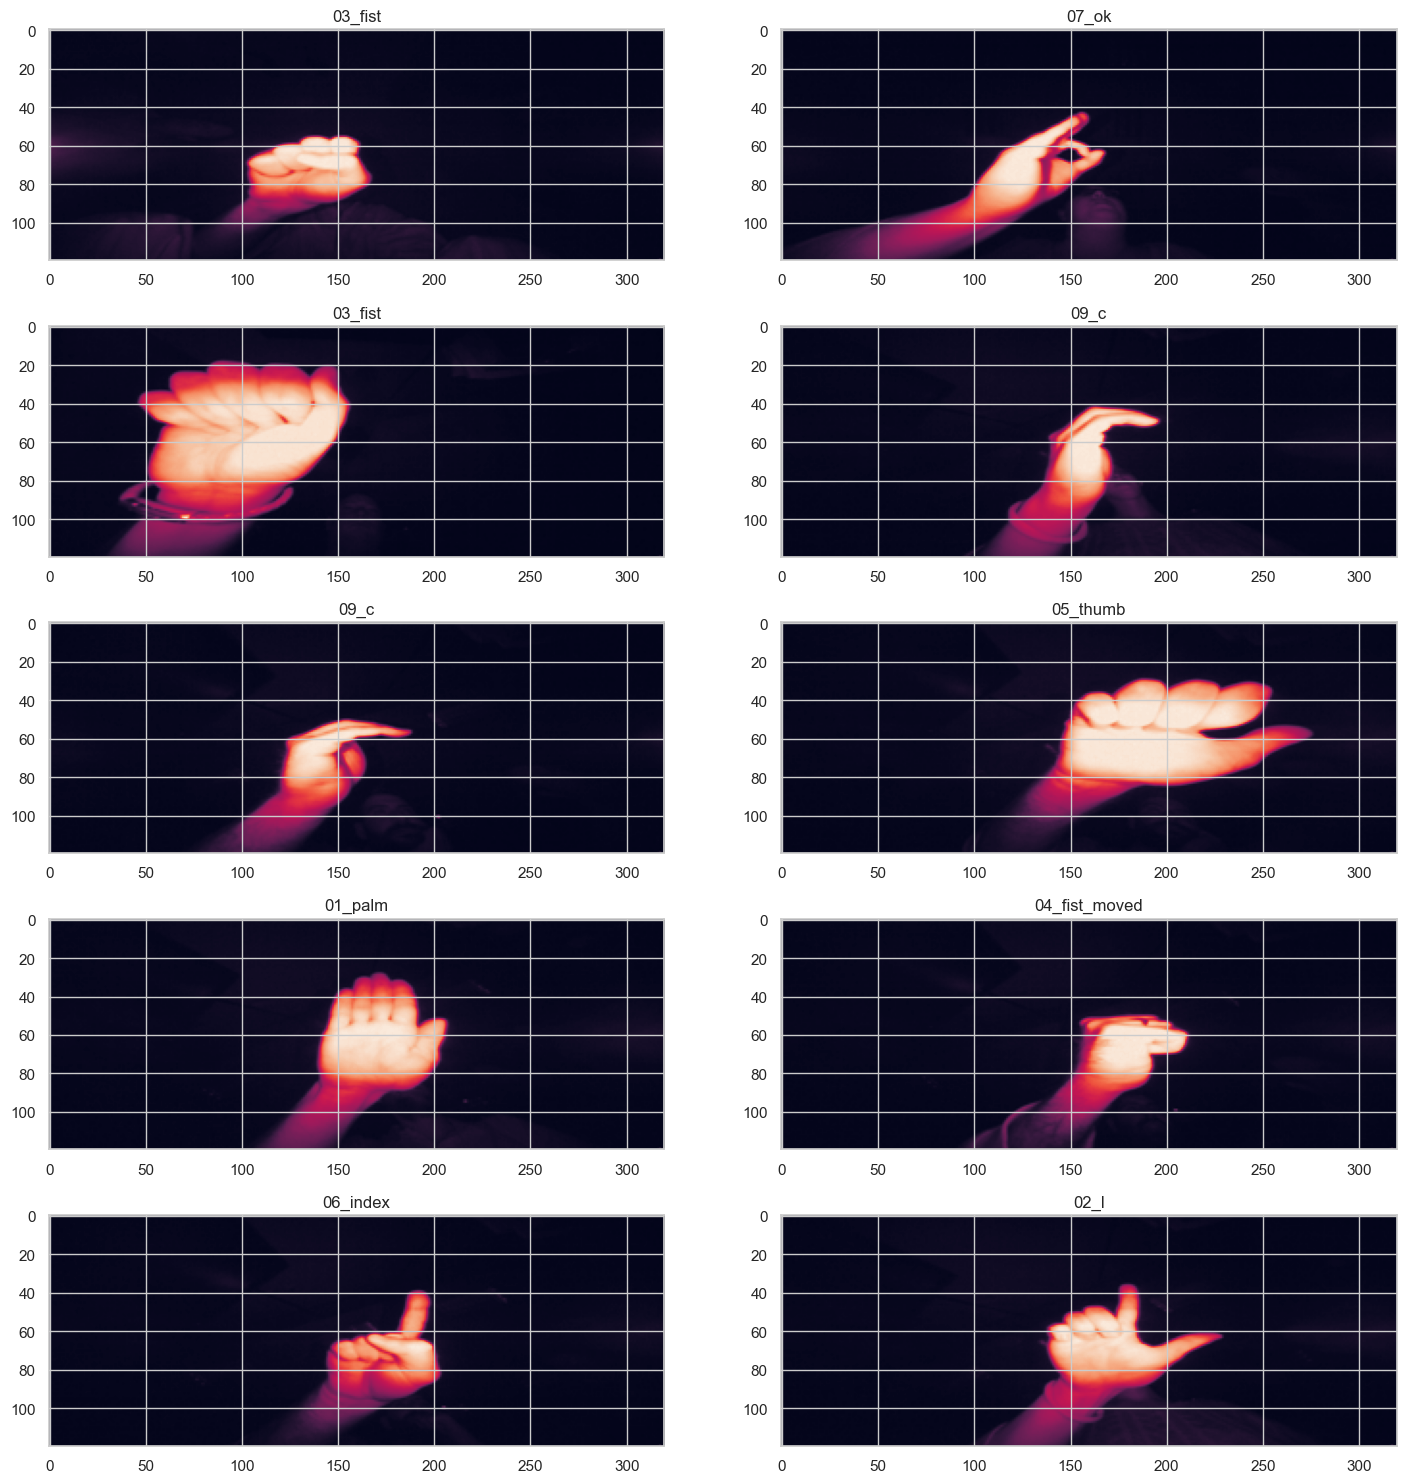

In [6]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(y_data))
        ax[i, j].imshow(x_data[l])
        ax[i, j].set_title(reverselookup[y_data[l]])

plt.tight_layout()

In [7]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, input_height, input_width, 1))

In [8]:
print(x_data.shape)
print(y_data.shape)
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2, random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5, random_state=42)

(20000, 120, 320, 1)
(20000, 10)


In [9]:
def add_noise(image):
    noise = np.random.normal(loc=0, scale=0.1, size=image.shape)  # You may adjust the scale based on your needs
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, -1.0, 1.0)  # Clip values to be in the valid range [-1, 1]
    return noisy_image.astype(np.float32)


# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=add_noise
)

In [10]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (input_height,input_width,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [11]:
batch_size=128
epochs=10

In [12]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [13]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 320, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 160, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 160, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 80, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 80, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 40, 96)       0

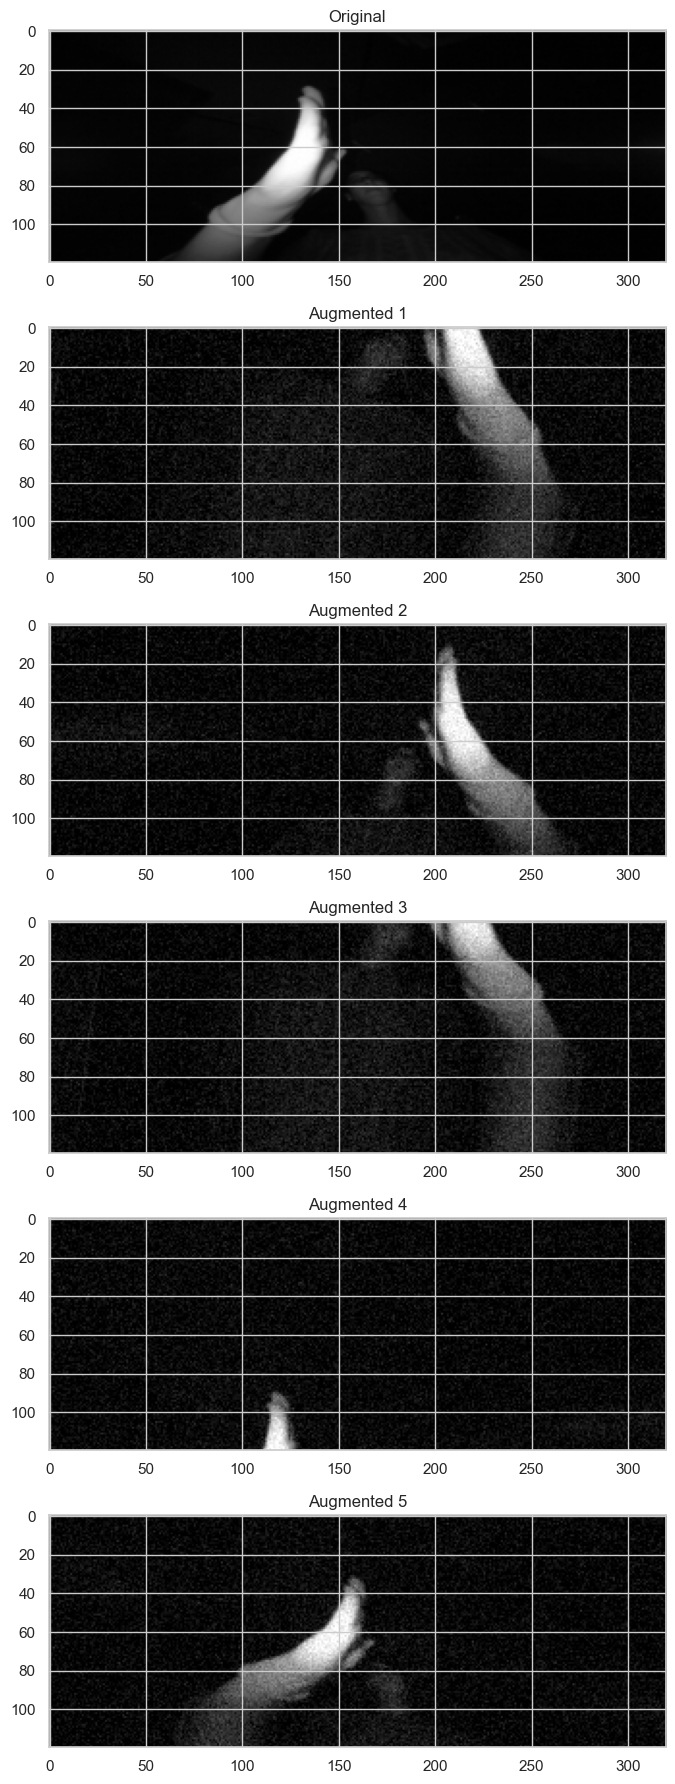

In [15]:
index = np.random.randint(0, len(x_train))

# Generate augmented images for visualization
augmented_images = []
for _ in range(5):  # Adjust the number of augmented examples to display
    batch = datagen.flow(x_train[index:index + 1], y_train[index:index + 1], batch_size=1)
    augmented_images.append(batch[0][0])

# Plot the original and augmented images in separate rows
plt.figure(figsize=(18, 3 * (1 + len(augmented_images))))
plt.subplot(1 + len(augmented_images), 2, 1)
plt.imshow(x_train[index].reshape(input_height, input_width), cmap='gray')
plt.title('Original')

for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1 + len(augmented_images), 2, 2 * (i + 1) + 1)
    plt.imshow(augmented_image.reshape(input_height, input_width), cmap='gray')
    plt.title(f'Augmented {i + 1}')



plt.tight_layout()
plt.show()

In [16]:
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
history = model.fit(train_generator, epochs=epochs, batch_size=batch_size, validation_data=(x_validate, y_validate))
#History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_validate, y_validate),callbacks=callbacks)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 1.9324 - accuracy: 0.2887
Epoch 1: val_loss improved from inf to 0.74837, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 294s 2s/step - loss: 1.9324 - accuracy: 0.2887 - val_loss: 0.7484 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 1.0333 - accuracy: 0.6401
Epoch 2: val_loss improved from 0.74837 to 0.28566, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 272s 2s/step - loss: 1.0333 - accuracy: 0.6401 - val_loss: 0.2857 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.7593
Epoch 3: val_loss improved from 0.28566 to 0.08653, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 280s 2s/step - loss: 0.6902 - accuracy: 0.7593 - val_loss: 0.0865 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.8074
Epoch 4: val_loss improved from 0.08653 to 0.04978, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 328s 3s/step - loss: 0.5418 - accuracy: 0.8074 - val_loss: 0.0498 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8290
Epoch 5: val_loss improved from 0.04978 to 0.02792, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 306s 2s/step - loss: 0.4809 - accuracy: 0.8290 - val_loss: 0.0279 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8481
Epoch 6: val_loss improved from 0.02792 to 0.01595, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 297s 2s/step - loss: 0.4200 - accuracy: 0.8481 - val_loss: 0.0159 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 7/10
125/125 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8575
Epoch 7: val_loss improved from 0.01595 to 0.00646, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 316s 3s/step - loss: 0.3908 - accuracy: 0.8575 - val_loss: 0.0065 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8658
Epoch 8: val_loss did not improve from 0.00646
125/125 [==============================] - 317s 3s/step - loss: 0.3651 - accuracy: 0.8658 - val_loss: 0.0124 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 9/10
125/125 [==============================] - ETA: 0s - loss: 0.3581 - accuracy: 0.8668
Epoch 9: val_loss did not improve from 0.00646
125/125 [==============================] - 323s 3s/step - loss: 0.3581 - accuracy: 0.8668 - val_loss: 0.0108 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 10/10
125/125 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8747
Epoch 10: val_loss improved from 0.00646 to 0.00456, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


125/125 [==============================] - 319s 3s/step - loss: 0.3430 - accuracy: 0.8747 - val_loss: 0.0046 - val_accuracy: 0.9990 - lr: 0.0010


In [17]:
History = history

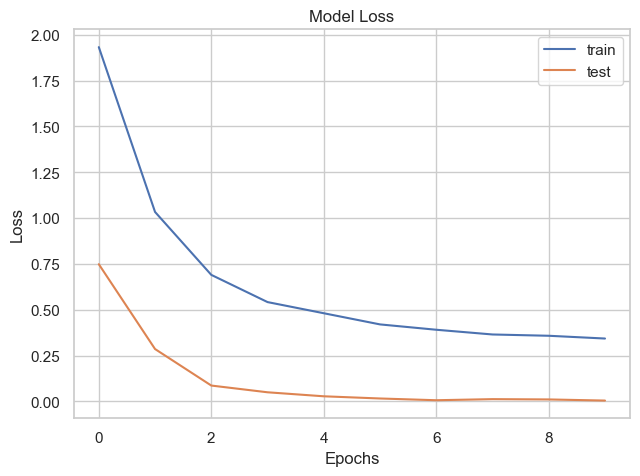

In [18]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

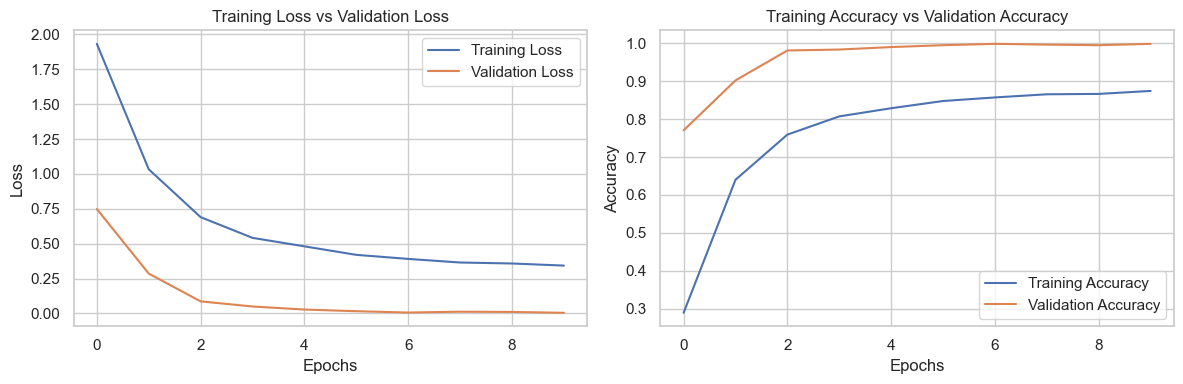

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 42ms/step


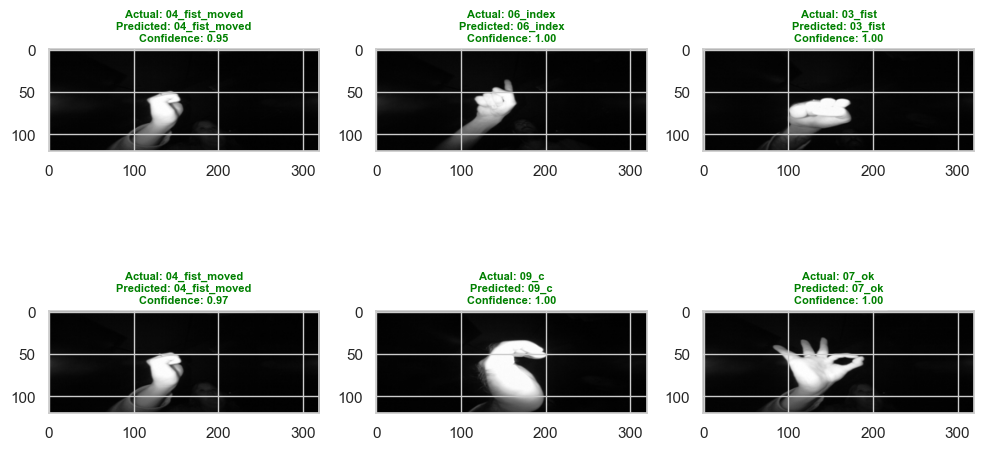

In [21]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you have a function to reverse lookup the class indices
def reverse_lookup(index):
    return reverselookup[index]

# Select random samples from the test set
num_samples_to_visualize = 6
random_indices = random.sample(range(len(x_test)), num_samples_to_visualize)
x_random_samples = x_test[random_indices]
y_random_labels = y_test[random_indices]  # Assuming y_test contains the true labels

# Make predictions on the randomly selected test samples
predictions_random = model.predict(x_random_samples)

# Visualize predictions for the randomly selected test samples in 2 rows
num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        # Plot the original image
        axes[i, j].imshow(x_random_samples[index].reshape(input_height, input_width), cmap='gray')

        # Print the confidence score in bold black color
        predicted_class = np.argmax(predictions_random[index])
        actual_class = np.argmax(y_random_labels[index])
        confidence = predictions_random[index][predicted_class]

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}\nConfidence: {confidence:.2f}', color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

63/63 [==============================] - 8s 125ms/step


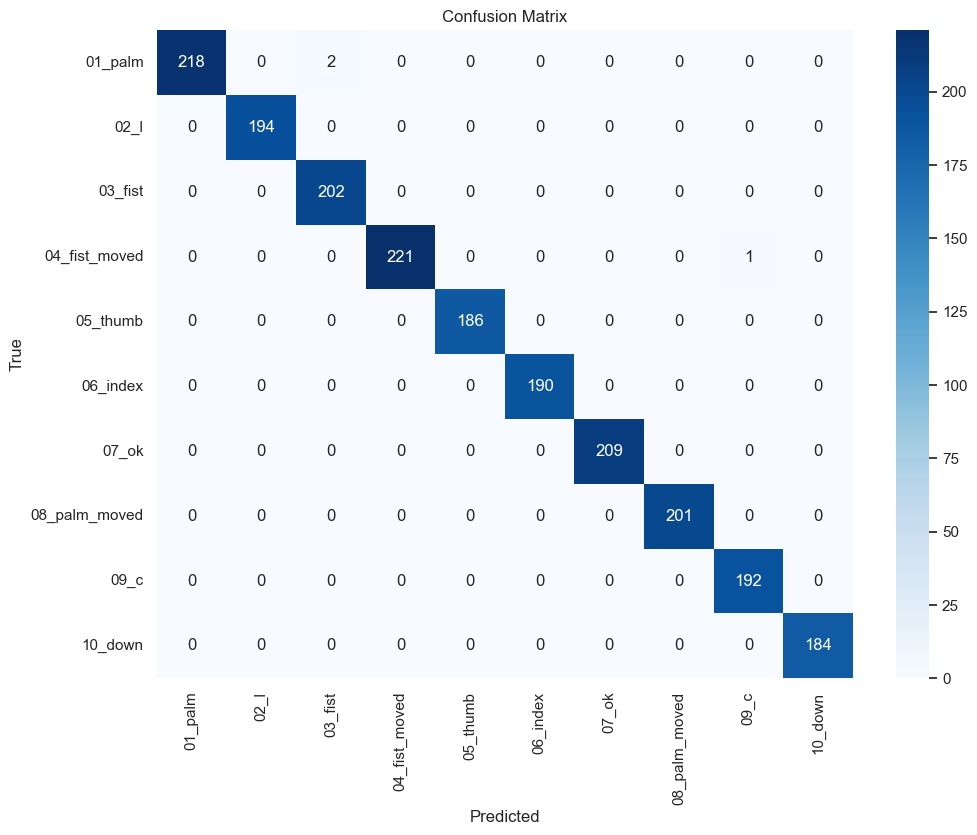

In [22]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

63/63 [==============================] - 7s 108ms/step


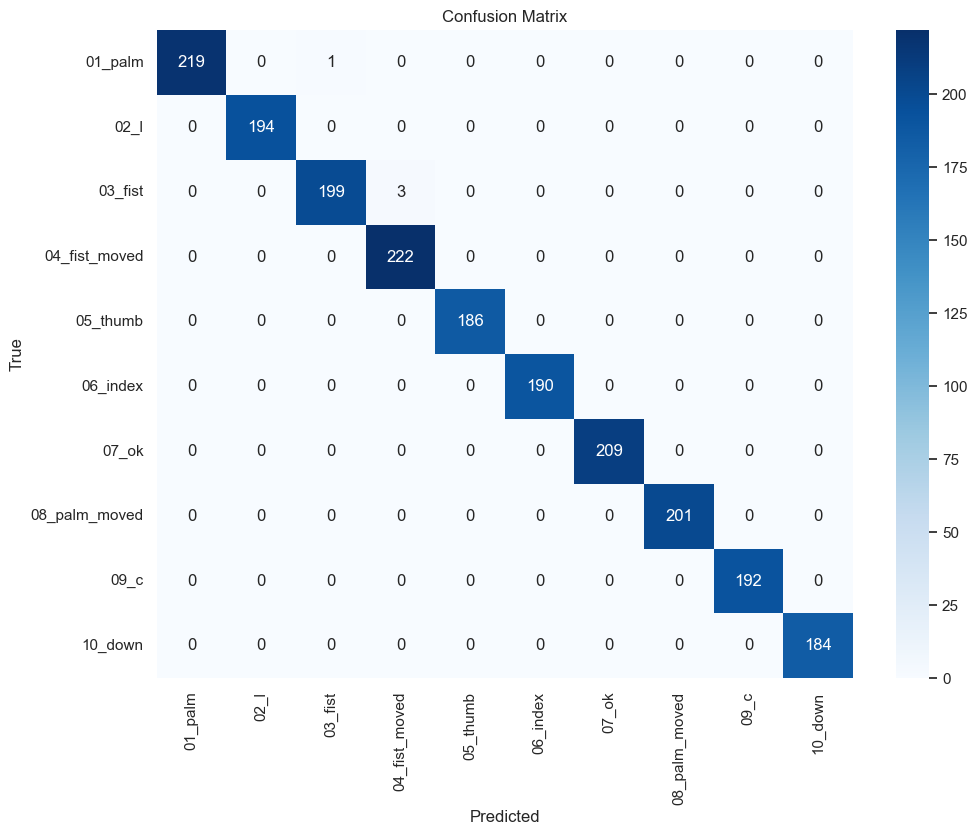

In [40]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()